<a href="https://colab.research.google.com/github/cagdastopcu/omission-of-visual-stimuli/blob/main/data_analysis_Cristian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-analysis setup
Setup process for importing Allen SDK materials and data:

A lot of this code is taken directly from https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_Allen_Visual_Behavior_from_SDK.ipynb

Install pip so we can install Allen's mindscope package.

In [ ]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

This notebook always needs to have the runtime restarted. There should be a button above this line.

Import dependencies. The usual stuff, scientific computing stuff, seaborn for plotting, mindscope from allen. AllenSDK's visual behavior packages.

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Here are the Allen packages:
import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

This dataset need to be downloaded somewhere, the default Allen code just uses a local temporary directory.

In [ ]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

# Setup the tables for the sessions and experiments:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.81MMB/s]
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 9.14MMB/s]
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.35MMB/s] 


# Looking through experiment directories to find useful data



Let's take a look at what the session table looks like. I think this is like a meta index of all the different sessions with a bunch of metadata about them.

In [ ]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


There are a ton of different properties. We want to look at different cell lines because they relate to the cell types we're interested in. Let's get the unique tags for "cre_line", just because the text output for that tag is pretty easy to read.

In [ ]:
drivers = session_table["cre_line"].unique()
print(drivers)

['Sst-IRES-Cre' 'Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']


Great, now we can get the indices of these cell types from the session table. Let's make a function I guess.

In [ ]:
def get_cell_type_index(cell_type,session_table):

    """Get the indexes of the Allen sessions that use a particular cre line.
    
    Args:
      cell_type:  a string of the name of the cre line you want. This uses regex so you can try to be less descriptive, like 'sst' is good enoguh for Sst-IRES-cre.
      session_table: The table containing the sessions from Allen.

    Returns:
      ix (1D array): An index of sessions that use that cre line.
    """

    # Look through the cre_line collumn and see if the cell_type string is contained in the output, then write down the index.
    ix = session_table.cre_line.str.contains(cell_type,regex=True).index

    return ix

test_ix = get_cell_type_index('slc',session_table)
print(test_ix)


Int64Index([ 951410079,  952430817,  954954402,  955775716,  957020350,
             958105827,  958772311,  959458018,  993727065,  993984066,
            ...
            1050633071, 1050946706, 1051120218,  960475393,  961180142,
             961665529,  962736894,  963496285,  964660947,  965319434],
           dtype='int64', name='ophys_session_id', length=551)


# Working with experiment ids


In [ ]:
ophys_session_id = test_ix[5]
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      457841
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                F
age_in_days                                                                      216
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     3
prior_exposures_to_session_type                                                    2
prior_exposures_to_image_set                                     

In [ ]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_958741219.nwb: 100%|██████████| 249M/249M [00:07<00:00, 32.6MMB/s]
behavior_ophys_experiment_958741222.nwb: 100%|██████████| 259M/259M [00:07<00:00, 34.2MMB/s]
behavior_ophys_experiment_958741230.nwb: 100%|██████████| 250M/250M [00:07<00:00, 32.6MMB/s]
behavior_ophys_experiment_958741232.nwb: 100%|██████████| 243M/243M [00:07<00:00, 32.9MMB/s]
behavior_ophys_experiment_958741234.nwb: 100%|██████████| 238M/238M [00:07<00:00, 32.8MMB/s]


In [ ]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 5/5 [00:25<00:00,  5.12s/it]


In [ ]:
mindscope_utilities.event_triggered_response?

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.


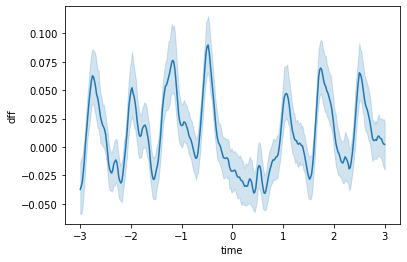

In [ ]:


cell_id = cell_ids[11]
etr = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)
etr

sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

Let's functionalize this, since we want these plots.

In [ ]:
def get_response(event_type, neural_data, c_id = 1, t_span = 3, plot = True):

  """Get the activity of a particular cell in response to an event
  
  Args:
    event_type: string that is a collumn in neural_data. e.g. 'omitted' or 'is_change'
    neural_data: the neural data table.
    c_id: cell id, which cell to get the response from.
    t_span: what timespan to sample, in seconds.
    plot: if true, a plot is generated.

  Returns:
    etr (1D array): The cell activity from -t_span s to +t_span s
  """
  cell_ids = neural_data['cell_specimen_id'].unique()
  cell_id = cell_ids[c_id]
  etr = mindscope_utilities.event_triggered_response(
  data = neural_data.query('cell_specimen_id == @cell_id'),
  t = 'timestamps',
  y = 'dff',
  event_times = stimulus_table.query(event_type)['start_time'],
  t_before=t_span,
  t_after=t_span,
  output_sampling_rate = 50,
    )
  etr

  if plot:
    sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
    ) 

  return etr

[1086614149 1086614819 1086613134 1086615201 1086613265 1086616398
 1086615620 1086614512 1086620813 1086621290 1086621629 1086624375
 1086622595 1086621068 1086624500 1086620446 1086622408 1086623189
 1086625354 1086624821 1086621968 1086622997 1086624990 1086623621
 1086618338 1086619804 1086617208 1086617703 1086617474 1086619247
 1086621003 1086610874 1086611101 1086609503 1086610123 1086610759
 1086610475 1086609699 1086609798 1086612438 1086612827 1086611670
 1086611955]


In [ ]:
get_response('is_change',neural_data,11,1,True)

,time,dff,event_number,event_time
0,-1.00,0.203044,0,315.47681
1,-0.98,0.203044,0,315.47681
2,-0.96,0.203044,0,315.47681
3,-0.94,0.203044,0,315.47681
4,-0.92,0.183557,0,315.47681
...,...,...,...,...
21609,0.92,0.119485,213,3909.99644
21610,0.94,0.137368,213,3909.99644
21611,0.96,0.137368,213,3909.99644
21612,0.98,0.137368,213,3909.99644


,time,dff,event_number,event_time
0,-2.00,-0.098405,0,312.45769
1,-1.98,-0.098405,0,312.45769
2,-1.96,-0.098405,0,312.45769
3,-1.94,-0.098405,0,312.45769
4,-1.92,-0.095552,0,312.45769
...,...,...,...,...
26728,1.92,-0.011624,132,3902.47360
26729,1.94,-0.016278,132,3902.47360
26730,1.96,-0.016278,132,3902.47360
26731,1.98,-0.016278,132,3902.47360


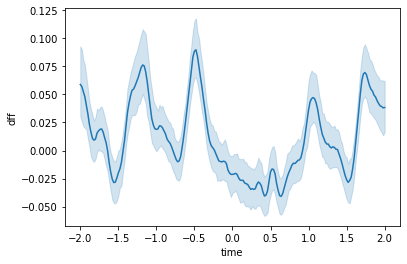

In [ ]:
get_response('omitted',neural_data,11,2,plot=True)

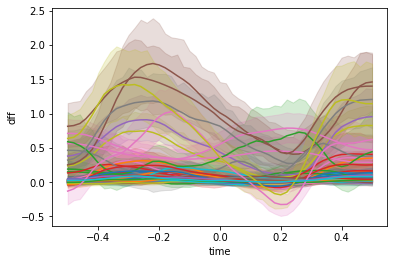

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
for c in range(len(cell_ids)):
  get_response('omitted',neural_data,c,.5,plot=True)

# Plotting means from cell types

In [ ]:
excitatory_cell_examples = get_cell_type_index('slc',session_table)
vip_cell_examples = get_cell_type_index('vip',session_table)
sst_cell_examples = get_cell_type_index('sst',session_table)

excitatory_cell_examples = excitatory_cell_examples[1]
vip_cell_examples = vip_cell_examples[1]
sst_cell_examples = sst_cell_examples[1]

exc_1 = session_table.loc[excitatory_cell_examples]
vip_1 = session_table.loc[vip_cell_examples]
sst_1 = session_table.loc[sst_cell_examples]

In [ ]:
experiments = {}
ophys_experiment_ids = session_table.loc[excitatory_cell_examples]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 4/4 [00:21<00:00,  5.28s/it]


In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
sample_data = get_response('omitted',neural_data,c,1,plot=False)
responses = np.zeros((len(sample_data),len(cell_ids)),dtype=float)
time = np.zeros((len(sample_data),len(cell_ids)),dtype=float)

for c in range(len(cell_ids)):
  dummy = get_response('omitted',neural_data,c,1,plot=False)
  responses[:,c] = dummy.dff
  time[:,c] = dummy.time


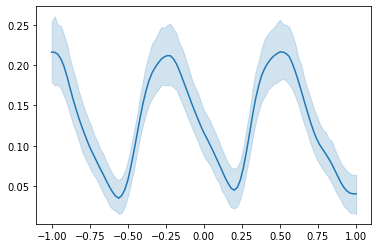

In [ ]:
sns.lineplot(
    x=time.mean(axis=1),
    y=responses.mean(axis=1)
    ) 